In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
import os, sys, time
import scipy.interpolate as interp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import hasasia.sensitivity as hassens
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [13]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [14]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import HorizonDistance as HD

import gwent
from gwent import binary,detector

load_directory = gwent.__path__[0] + '/LoadFiles/'

LISA_Other_filedirectory = load_directory + 'LISA_Other/StrainFiles/'
LISA_Neil_filedirectory = load_directory + 'LISA_Neil/StrainFiles/'
LISA_ESA_filedirectory = load_directory + 'LISA_ESA/StrainFiles/'
ET_filedirectory = load_directory + 'EinsteinTelescope/StrainFiles/'
aLIGO_filedirectory = load_directory + 'aLIGO/StrainFiles/'
NANOGrav_filedirectory = load_directory + 'NANOGrav/StrainFiles/' 
EOBdiff_filedirectory = top_directory + '/LoadFiles/DiffStrain/EOBdiff/'

In [15]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

In [16]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 3

In [17]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'T_obs' - Observation Time
        SOURCE:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
        LISA ONLY:
            'L' - Armlength
            'A_acc' - Acceleration Noise
            'A_IMS' - Optical Metrology
            'f_acc_break_low'
            'f_acc_break_high'
            'f_IMS_break'
        PTAs ONLY:
            'N_p' - Number of Pulsars
            'sigma' - Timing Error RMS
            'cadence' - cadence
'''
var_x = 'M' #Variable on x-axis

sampleRate_x = 10 #Number of x-axis points

In [18]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal

# Source Selection

In [19]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10

    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85

    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3

    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

# Model Selection

In [20]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        #Loaded from http://www.et-gw.eu/index.php/etsensitivities
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        #Loaded from https://dcc.ligo.org/T1800044/public
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds

        N_p = 18 #Number of pulsars

        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year

        instrument = detector.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]


    elif model == 3: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds

        N_p = 20 #Number of pulsars

        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year

        instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 4: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        T_type = 'A'

        instrument = detector.SpaceBased('Alt_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    else: #L3 proposal
        #Default Params from https://arxiv.org/abs/1702.00786
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        T_type = 'N'

        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    return instrument

# Horizon Distance Calculation

In [21]:
rho_thresh = 5
model = 5
instrument = Get_Instrument(model)
source = Get_Source(model)

In [26]:
start = time.time()
[_,_,z_init] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh)
[sample_x,DL_array,z_array] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,redshift_array=z_init)
end = time.time()
print(end-start)

False
False
False
False
False
False
False
False
False
False
[1.00000000e-05 7.87841258e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05]
False
False
False
False
False
False
False
False
False
False
[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
0.15748214721679688


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/Functions/HorizonDistance.py:84: RuntimeWarning: divide by zero encountered in log10
  if np.log10(DL.value) < -3:


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/Functions/HorizonDistance.py:290: RuntimeWarning: divide by zero encountered in log10
  dists_max = np.max(np.ceil(np.log10(DL_array)))


ValueError: Maximum allowed size exceeded

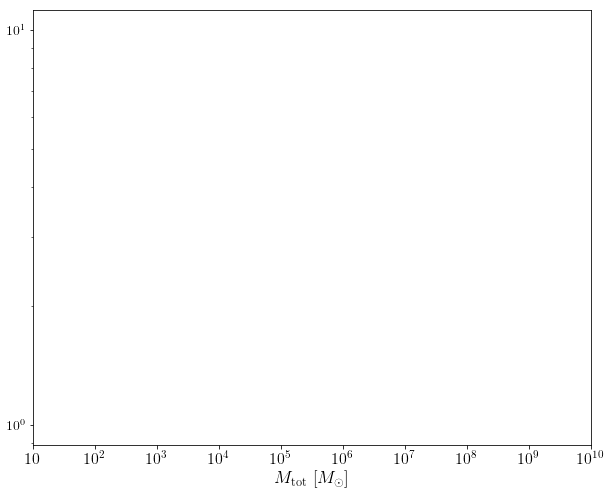

In [21]:
HD.plotHD(source,instrument,var_x,sample_x,DL_array,display=True,figloc=None)

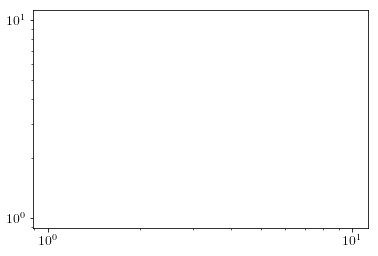

In [22]:
dists = np.linspace(-2,4,len(DL_array[:-10]))
dists = 10**dists*u.Gpc
z = [z_at_value(cosmo.luminosity_distance,dist) for dist in dists]
plt.figure()
plt.loglog(z,dists)
plt.loglog(z_init[:-10],DL_array[:-10])
plt.show()

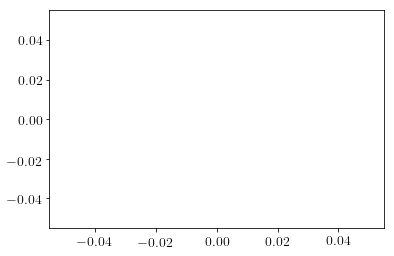

In [23]:
plt.plot(z,dists-DL_array[:-10])

In [27]:
rho_thresh = 5
model = 5
instrument = Get_Instrument(model)
source = Get_Source(model)
i = 0
iter_max = 3
tol = 1e-10

plt.figure()
while i < 2:
    print(i)
    if i == 0:
        #initial guess
        z_0 = np.ones(sampleRate_x)*10**np.random.uniform(-3,3,size=sampleRate_x)
        [_,DL_n,z_n] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,\
                                                    redshift_array=z_0)
        #Next z
        z_n_plus_1 = z_n*np.random.uniform(0,1,size=np.shape(z_n))
        print(z_n_plus_1-z_n)
    else:
        #Moving previous values back one slot
        z_n_minus_1 = z_n
        z_n = z_n_plus_1
        DL_n_minus_1 = DL_n
        #Uses z_n_plus_1 from previous to get new z_n
        [_,DL_n,z_n] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,\
                                                    redshift_array=z_n)
        #Next z
        print(DL_n*(z_n-z_n_minus_1)/(DL_n-DL_n_minus_1))
        z_n_plus_1 = z_n - DL_n*(z_n-z_n_minus_1)/(DL_n-DL_n_minus_1)

    #HD.plotHD(source,instrument,var_x,sample_x,DL_n_minus_1,display=True,figloc=None)
    #plt.plot(z_n_minus_1,DL_n_minus_1)
    i+=1


0
False
False
False
False
False
False
False
False
False
False
[-8.96123368e-06 -5.31704858e-06 -4.39461100e-06 -5.58372480e-07
 -7.62572773e-06 -1.42250677e-06 -2.36923698e-06 -5.60478413e-06
 -7.85836903e-06 -2.89628725e-07]
1
False
False
False
False
False
False
False
False
False
False
[nan nan nan nan nan nan nan nan nan nan]


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/Functions/HorizonDistance.py:84: RuntimeWarning: divide by zero encountered in log10
  if np.log10(DL.value) < -3:
/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Figure size 432x288 with 0 Axes>

In [ ]:
HD.plotHD(source,instrument,var_x,sample_x,DL_n_minus_1,display=True,figloc=None)

In [ ]:
rho_thresh = 5
for model in range(6):
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    [sample_x,DL_array] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh)
    HD.plotHD(source,instrument,var_x,sample_x,DL_array)